<h1>
<center>
Final Exam - take home portion
</center>
</h1>
<div class=h1_cell>
<p>
You will need to finish this takehome portion of the final exam before arriving for the in-class exam. The in-class portion will build on your answer here.
  <p>
    There is only 1 question on the takehome portion. It is worth 15 points of the final. But as noted, you need to finish it to be sucessful on the in-class portion.
    <p>
      I'll give you some new content and then ask the question.

<h2>Bring in library from module 8</h2>
<p>
  We don't need the batch version so I am importing from deep_1.


In [0]:
!rm library_w19_deep_1.py

rm: cannot remove 'library_w19_deep_1.py': No such file or directory


In [0]:
from google.colab import files
files.upload()

Saving library_w19_deep_1.py to library_w19_deep_1.py


{'library_w19_deep_1.py': b"import pandas as pd\nimport numpy as np\n\ndef sigmoid(x):  \n    return 1/(1+np.exp(-x))\n\ndef mse(z,y):\n  return (z-y)**2\n\ndef mse_der(z,y):\n  return z-y\n\ndef sigmoid_der(x):  \n    return sigmoid(x)*(1-sigmoid(x))\n\ndef ann_simple(all_samples, labels, weights, bias, hypers={}):\n  \n  '''\n  Can build an ANN with n input nodes and one output node.\n  Uses sigmoid and mse.\n  '''\n  \n  input_n = all_samples.shape[1]  #number of inputs in each sample\n  \n  assert weights.shape == (input_n,1), 'weights needs to have same shape as sample'\n  assert all_samples.shape[0] >= 1, 'all_samples must represent 1 or more samples'\n  assert bias.shape == (1,) , 'a single bias weight for output node'\n  assert labels.shape[1] == 1, 'actual value for the 1 output node'\n  assert labels.shape[0] == all_samples.shape[0], 'labels must match up with samples'\n  \n  hyper_keys = [*hypers]  #fails on 2.7\n  target_set = set(['epochs', 'cost-reporting', 'learning-rate

In [0]:
from library_w19_deep_1 import *

%who function

ann_predictor	 ann_simple	 ann_tester	 from_scratch	 mse	 mse_der	 sigmoid	 sigmoid_der	 


In [0]:
import numpy as np
import pandas as pd

<h2>An upgrade to our week 8 code</h2>

I want to look at an ANN  that will have multiple input and multiple output nodes. We started to be a bit elastic in week 8 by allowing any number of input nodes. I want to go full-elastic and allow any number of ouput nodes. So I'll generate weights based on the length of a sample and the length of a label.
<p>
  I am going to set myself a challenge. I want to avoid any constants other than hyper-parameters. So don't want to hard-wire in how many nodes I will have. I'd also like to avoid for loops. Instead, I want to build on the powerful vector and matrix operations numpy provides. You can see if I meet the challenge.

<h2>Using a Dot Product</h2>

In week 8 we used `np.multiply` and `np.sum` to compute the raw input to the output nodes. We then used that raw input as argument to sigmoid to get the final output. I want to use something a little more sophisticated to replace those 2 separate operations.  It is called a dot product. And to show it off, I am going to introduce a more complicated ANN that has 3 inputs and 3 outputs. Check out the image below.
<p>
  <img src='https://www.dropbox.com/s/7zjjpft0ulbh0ah/dot3.png?raw=1'>
  <p>
    Assume we have 3 input nodes and 3 output nodes. We will expand this to a larger dimension in a minute but same idea will apply. To feed forward, I need to come up with a raw input to each of the 3 output nodes. We will need 9 link weights and 3 bias weights, right? As you can see, each output node has 3 links coming into it: one from in1, one from in2, one from in3. In the diagram above, you can view the first column in the 3x3 matrix as the weights for all the links coming into out1, the second column as the weights for out2, the third column as the weights for out3. I am omitting the bias weights for now. But there would be a vector of the 3 bias weights as well.
    <p>
      For the row on the left, you can view in1 as the value for the in1 node, etc.
      <p>
        Ok, the cool part. I can use a dot-product to get the raw input values for the 3 output nodes. The resulting row holds those 3 values.  Let's check it out with code.

In [0]:
weights = np.array([[0, 1, 2],  #test values for weights
              [3, 4, 5],
             [6, 7, 8]])

In [0]:
biases =  np.array([-1, -2, -3])

In [0]:
sample = np.array([.10,.20,.30])  #test values for one sample

In [0]:
raw = sample.dot(weights)  #raw input to each output node
raw

array([2.4, 3. , 3.6])

You should convince yourself that raw[0] is the sum of products of column 0 in the matrix, etc.

In [0]:
full_raw = np.add(raw, biases)
full_raw

array([1.4, 1. , 0.6])

<h2>You've heard of GPUs and Deep Learning?</h2>

Taking the dot product is one of the things GPUs (Graphical Processing Units) excel at. Hope you can see that the dot product is highly parallelizable. And that parrallelization is one of the tricks a GPU can perform. High-powered GPUs grew out of the gaming industry and now have been harnessed for neural nets. Nvidia is the major player in the field.
<p>
  BTW: You can choose to use a GPU on colab. Go under Runtime and Change Runtime Type. You will see GPU as an option. Spoiler alert: you won't see any difference in performance until you get to ANNs with 1000s of inputs and millions of weights. But as reminder, everything we are doing in class does scale. Same basic forward and backward propogation operations apply in small nets and huge nets.
  <p>
    You will also see the option of a TPU. This is not a separate chip like a GPU, but a co-processor that runs with your CPU. It stands for Tensor Processing Unit. Google invented it. You probably have questions. What is a tensor? Look at weights above. It is a tensor! So most of the things we have been doing with vectors and matrices has a fancier name of 1D and 2D tensors. Is a TPU better than a GPU? Not in performance. But yes in cost and energy consumption (and heat generated). There is a reason google built one of their server-farms in the Dalles: it is right next to the Bonneville Power Plant!
    <p>
      Here is further discussion of GPU and TPU: https://www.quora.com/How-different-is-a-TPU-from-GPU

<h2>Vectorize the activation function</h2>

There is another place that has potential for parallelism. Once we have our 3 raw inputs to the 3 output nodes, we need to apply sigmoid to each. I could do this with a map. And this should tell you there is parallelization potential: any map operation has potential to be made parallel. So here is the map code. Why all high values? Remember what sigmoid does with large values.

In [0]:
zm = list(map(sigmoid, full_raw))
zm

[0.8021838885585817, 0.7310585786300049, 0.6456563062257954]

Here is an alternative way that perhaps has more potential given the community interest in cranking the performance on all the numpy operations.

In [0]:
fsig = np.vectorize(sigmoid)
zv = fsig(full_raw)
zv

array([0.80218389, 0.73105858, 0.64565631])

This gives us our 3 ouput values and ends forward propogation.

<h2>Computing error (AKA cost)</h2>

We have 3 separate costs to compute, one for each of the 3 output nodes. I am going to use a map.
<p>
  Let's say the label is [4,4,3]. I know this is slightly weird. We have always been using target columns (e.g., Survived, Loan_Status) that have a single binary value. What's up with 3 values? For our toy example, it is weird. You will have to wait a bit to see its actual use. Hint: we will need to one-hot encode the label.

In [0]:
label = np.array([4,4,3])  #the actual value that goes with the sample - not very motivating at moment

costs = np.array([mse(a,b) for (a,b) in zip(zv, label)])  #will get 3 costs for the 3 output nodes

costs

array([10.22602788, 10.68597802,  5.54293423])

That ends forward propogation. Let's take a look at backward propogation. If we think about it, we will need to backpropogate from the 3 output nodes individually. Each output node leads to 3 weights. When we finish all 3 we will have updates for all 9 weights (and the 3 bias weights).
<p>
  Let's get started.

In [0]:
#3 output nodes so 3 mse_der values to compute


mse_deriv_values = np.array([mse_der(a,b) for (a,b) in zip(zv, label)])
mse_deriv_values

array([-3.19781611, -3.26894142, -2.35434369])

Next up: sigmoid.

In [0]:
fsig_der = np.vectorize(sigmoid_der) #using numpy built-in mapping function

sigmoid_deriv_values = fsig_der(raw)
sigmoid_deriv_values

array([0.076255  , 0.04517666, 0.02588959])

The 3 z_delta values up next.

In [0]:
z_deltas = np.multiply(mse_deriv_values, sigmoid_deriv_values)
z_deltas

array([-0.24384946, -0.14767985, -0.060953  ])

Now ready to update all 9 weights.

In [0]:
#Step 1

weight_changes = [sample*z_deltas[i] for i in range(len(z_deltas))]
weight_changes

[array([-0.02438495, -0.04876989, -0.07315484]),
 array([-0.01476799, -0.02953597, -0.04430396]),
 array([-0.0060953, -0.0121906, -0.0182859])]

Unfortunately, the change matrix does not line up with our weight matrix. The weights are column-based. Column 0 represents all the links coming into output node 0. What we have above is all the links coming into output node 0 as the row 0. Solution? Several. Pick your poison.

In [0]:
#step 2 - alternative 1

wt = np.transpose(weight_changes)
wt

array([[-0.02438495, -0.01476799, -0.0060953 ],
       [-0.04876989, -0.02953597, -0.0121906 ],
       [-0.07315484, -0.04430396, -0.0182859 ]])

In [0]:
#step 2 - alternative 2

ws = np.column_stack(weight_changes)
ws

array([[-0.02438495, -0.01476799, -0.0060953 ],
       [-0.04876989, -0.02953597, -0.0121906 ],
       [-0.07315484, -0.04430396, -0.0182859 ]])

We now have the weights and changes to the weights aligned. Watch how slick it is to update.

In [0]:
#just as reminder, here are the weights
weights

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [0]:
weights = np.subtract(weights, wt)  #going with the transpose version
weights

array([[0.02438495, 1.01476799, 2.0060953 ],
       [3.04876989, 4.02953597, 5.0121906 ],
       [6.07315484, 7.04430396, 8.0182859 ]])

The biases are easy peasy.

In [0]:
biases = np.subtract(biases, z_deltas)
biases

array([-0.75615054, -1.85232015, -2.939047  ])

<h2>I think we have it</h2>

You have all the pieces for a new function `ann_flex`. Go ahead and write it.

<h2>Final exam question 1: define ann_flex (15 points)</h2>
<p>
  Use ann_simple as your basis. In particular, we will not be using ann_simple_batch. I started it for you below.

In [0]:
def ann_flex(all_samples, all_labels, weights, biases, hypers={}):
  
  '''
  Can build an ANN with n input nodes and m output nodes.
  Uses sigmoid and mse.
  '''
  
  input_n = all_samples.shape[1]  #number of inputs in each sample
  output_n = all_labels.shape[1]      #number of outputs in each label
  
  assert weights.shape == (input_n,output_n), 'weights needs to have same shape as sample'
  assert all_samples.shape[0] >= 1, 'all_samples must represent 1 or more samples'
  assert biases.shape == (output_n,) , 'a bias weight for each output node'
  assert all_labels.shape[0] == all_samples.shape[0], 'labels must match up with samples'
  
  hyper_keys = [*hypers]  #fails on 2.7
  target_set = set(['epochs', 'cost-reporting', 'learning-rate'])  #might add more later
  diff_set = set(hyper_keys) - target_set
  if diff_set: print('WARNING: unrecognized hyper parameters ' + str(diff_set))

  max_epochs = hypers['epochs'] if 'epochs' in hypers else 100
  cost_reporting = hypers['cost-reporting'] if 'cost-reporting' in hypers else 100  #how often to report epoch cost
  alpha = hypers['learning-rate'] if 'learning-rate' in hypers else .05
  
 

I'll give you the next one. Notice I changed the weight creation code a bit. I moved weights between -.1 and +.1. It's one heuristic out of many for generating initial weights of an ANN.

In [0]:
def from_scratch_flex(samples, labels, hypers):
  
  input_n = samples.shape[1]
  output_n = labels.shape[1]
  
  #reset weights to initial values. Seed of 42 guarantees same random values
  np.random.seed(42)
  weights = .2*np.random.rand(input_n,output_n) - .1
  biases = np.random.rand(output_n)
  
  return ann_flex(samples, labels, weights, biases, hypers)

In [0]:
#test with 2 input nodes and 3 output nodes

test_samples = np.array([[.1,.2], [.4,.5]])
test_labels = np.array([[1,0,0], [0,0,1]])  #notice one-hot encoded

from_scratch_flex(test_samples, test_labels, hypers={'epochs':10, 'cost-reporting': 1})

(0, 1.0248370947474648)
(1, 0.9150220318962172)
(2, 0.8159534381771475)
(3, 0.7378534387504471)
(4, 0.680950671446293)
(5, 0.640234274488902)
(6, 0.610501870499008)
(7, 0.587984873656967)
(8, 0.5702434582005558)
(9, 0.555738124644553)


(array([[-0.40240815, -0.33955348,  0.31486134],
        [-0.3574284 , -0.68043077,  0.15884282]]),
 array([ 0.05964438, -0.95320536,  0.19292864]))

Note that I am printing the total cost above. The total cost is the simple sum of the cost of each of the output nodes.

In [0]:
def ann_flex_predictor(sample, weights, biases):
  fsig = np.vectorize(sigmoid)
  
  #do forward propogation
  raw = sample.dot(weights)
  full_raw = np.add(raw, biases)
  final_output = fsig(full_raw) #an array of values for output nodes

  return final_output

Just copying weights and biases from above. And made up test sample.

In [0]:
ann_flex_predictor(np.array([.2,.3]), np.array([[-0.40240815, -0.33955348,  0.31486134], [-0.3574284 , -0.68043077,  0.15884282]]), np.array([ 0.05964438, -0.95320536,  0.19292864]))
    

array([0.46802724, 0.22701469, 0.57531103])

Is that a good answer for the 3 ouput nodes? Who knows :) It is just a made up example. We can try something more realistic in a minute.
<p>
  Finally, we can define a tester that will produce the list of predictions that go with the list of samples.

In [0]:

def ann_flex_tester(samples,  weights, biases):
  
  predictions = [ann_flex_predictor(s, weights, biases) for s in samples] #an array of arrays
  
  return predictions

In [0]:
predictions = ann_flex_tester(np.array([[.2,.3], [.3, .4], [.4,.5]]), np.array([[-0.40240815, -0.33955348,  0.31486134], [-0.3574284 , -0.68043077,  0.15884282]]), np.array([ 0.05964438, -0.95320536,  0.19292864]))

In [0]:
predictions

[array([0.46802724, 0.22701469, 0.57531103]),
 array([0.44916391, 0.20961565, 0.58684167]),
 array([0.43044567, 0.1932168 , 0.59827785])]

From this point I could get the labels and comare predictions against them. Given this is a toy example, it won't make much sense. Let's look at a more realistic example.

<h2>Another test case for your code</h2>
<p>
  Let's look at one of the iconic data sets for deep learning. I like it because it shows that virtually any kind of data can be a target for an ANN. The data set is the pixels from a large set of hand-drawn digits, 0 through 9. Each image is 28 by 28 pixels. Each pixel will have a value between 0 and 255 to denote the grayscale of that pixel.
  <p>
    The base data set has 60,000 training images and 10,000 testing images. We are going to cut that down to 1,000 each. We will also normalize the pixel value. Here is the cool part. The whole thing has been packaged up by a package called keras. Check out the code below.

In [0]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()


Using TensorFlow backend.


We now have a training set (x_train, y_train) and a test set (x_test, y_test). Let's do some more wrangling.

In [0]:

images, labels = (x_train[0:1000].reshape(1000,28*28) / 255,
                  y_train[0:1000])


So `images` is our feature set and `labels` are our labels. Note that I have flattened out the 28 by 28 matrix into a single vector of 784. So I will have 784 input nodes. I also normalized the values by dividing by the max, 255. I also chopped down to 1000 items.

In [0]:
images.shape

(1000, 784)

Let's look some of the pixel values in the first image, which we will see later is a hand-written 5.

In [0]:
images[0][:200]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

Wrangle the labels next.

In [0]:
labels.shape

(1000,)

In [0]:
labels[0]

5

This is not ideal for ANN output. It is true we would only need one output node the way things are. It would spit out values between 0 and 9. We will find it better to one-hot encode the labels (CIS472), giving us 10 output nodes per image. Let's do that.

In [0]:
one_hot_labels = np.zeros((len(labels),10))
for i,l in enumerate(labels):
    one_hot_labels[i][l] = 1
labels = one_hot_labels
labels.shape

(1000, 10)

We now have labels with 10 values per sample. Let's look at first. We should all 0s except for a 1 in the 6th position.

In [0]:
labels[0]  #the ohe of 5 from range 0 to 9

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

Do same thing for test images.

In [0]:

test_images = x_test.reshape(len(x_test),28*28) / 255
test_labels = np.zeros((len(y_test),10))
for i,l in enumerate(y_test):
  test_labels[i][l] = 1
test_labels[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

The digit 7, correct? This is cool: we have a way to visualize the actual 28 by 28 matrix.

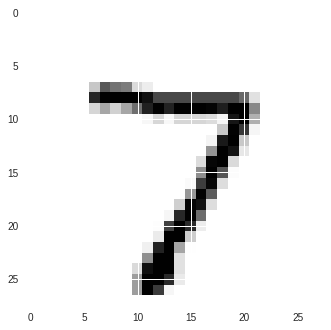

In [0]:
from matplotlib import pyplot as plt
first_image = x_test[0]
pixels = first_image.reshape((28, 28))  #convert it back into the matrix form
plt.imshow(pixels)
plt.show()

Here is a visualization of the ann we will build.
<p>

<img src='https://www.dropbox.com/s/20zwd4blrnaggrw/Screenshot%202019-03-03%2009.39.00.png?raw=1' width='300' height='400'>

Ok, I am ready for training. I am going to time this and show my results below. I started at 1000 epochs and worked my way up. I am including the result I got for 10,000 epochs. I did it before I started timing. It is close enough to 3,000 that I am just going to use that.

<pre>
(1000, 0.056168013147983)
elapsed time: 200.64850234985352  (with GPU 226.79888653755188). So much for GPU boosting performance!

(2000, 0.04659837399874399)
elapsed time: 447.965735912323

(3000, 0.04401768636464867)
elapsed time: 692.5456459522247

(10000, 0.04400429181679943)
A long time!


In [0]:
import time

start = time.time()

(model_weights, model_biases) = from_scratch_flex(images, one_hot_labels, hypers={'epochs':3000, 'cost-reporting': 1000})

end = time.time()
print('elapsed time: '+ str(end - start))  # in seconds

(0, 0.6193040115499521)
(1000, 0.05616087601348139)
(2000, 0.04659580009774936)
(3000, 0.04401768636464867)
elapsed time: 696.7748854160309


In [0]:
model_weights[:10][:10]  #out of a total of 784 x 10

array([[-0.02509198,  0.09014286,  0.04639879,  0.0197317 , -0.06879627,
        -0.0688011 , -0.08838328,  0.07323523,  0.020223  ,  0.04161452],
       [-0.0958831 ,  0.09398197,  0.06648853, -0.05753218, -0.06363501,
        -0.0633191 , -0.03915155,  0.00495129, -0.013611  , -0.04175417],
       [ 0.02237058, -0.07210123, -0.04157107, -0.02672763, -0.008786  ,
         0.05703519, -0.06006524,  0.00284689,  0.01848291, -0.09070992],
       [ 0.02150897, -0.06589518, -0.08698968,  0.08977711,  0.09312641,
         0.06167947, -0.03907725, -0.08046558,  0.03684661, -0.0119695 ],
       [-0.07559235, -0.00096462, -0.0931223 ,  0.08186408, -0.048244  ,
         0.03250446, -0.03765778,  0.0040136 ,  0.00934206, -0.06302911],
       [ 0.09391693,  0.05502656,  0.08789979,  0.07896547,  0.01958   ,
         0.08437485, -0.0823015 , -0.06080343, -0.09095454, -0.03493393],
       [-0.02226454, -0.04573019,  0.0657475 , -0.02864933, -0.0438131 ,
         0.00853922, -0.07181516,  0.0604394 

In [0]:
model_biases  #10 of them

array([-1.77871279, -0.57293872, -3.05380539, -3.07492339, -0.72955601,
        0.05552463, -0.58926611, -0.69084225, -8.7103922 , -5.67148457])

In [0]:
preds = ann_flex_tester(test_images, model_weights, model_biases)  #notice I am using test images
preds[:10]

[array([9.19811610e-06, 7.03891256e-19, 1.49362739e-06, 2.86423684e-06,
        4.11103865e-09, 5.59917878e-09, 1.07389335e-18, 9.99999999e-01,
        1.24395995e-06, 9.88044143e-10]),
 array([1.76403288e-04, 4.26054156e-14, 1.56935879e-02, 3.42238540e-07,
        9.60528724e-20, 2.59065126e-02, 4.08372291e-02, 1.36667949e-24,
        2.70159062e-10, 2.94848821e-10]),
 array([2.05976144e-10, 9.99990279e-01, 3.63423311e-04, 5.08178824e-04,
        1.01339255e-09, 1.13162435e-09, 2.30406867e-04, 2.16070967e-04,
        6.12980628e-07, 6.25444204e-06]),
 array([9.99704139e-01, 2.25596812e-22, 1.98534182e-13, 1.61686101e-21,
        1.91259175e-20, 2.44881025e-08, 1.13259696e-10, 6.46448406e-05,
        2.93523747e-12, 1.52114413e-32]),
 array([4.39031133e-09, 1.09730569e-10, 1.45262422e-07, 1.02526208e-11,
        9.99912751e-01, 9.54376115e-16, 7.22668995e-05, 2.14774896e-06,
        5.88261510e-05, 1.33513915e-07]),
 array([9.79143990e-13, 9.99845557e-01, 5.55447731e-05, 4.94764691e-05

I am going to convert preds from one-hot to actual value by taking the index of the largest value in the 10 outputs. The `numpy argmax` function does what I want.

In [0]:
preds_values = [np.argmax(p) for p in preds]
preds_values[:10]

[7, 6, 1, 0, 4, 1, 4, 9, 2, 9]

In [0]:
zipped = list(zip(preds_values, y_test[0:1000]))  #notice I am using test labels
zipped[:10]

[(7, 7),
 (6, 2),
 (1, 1),
 (0, 0),
 (4, 4),
 (1, 1),
 (4, 4),
 (9, 9),
 (2, 5),
 (9, 9)]

In [0]:
sum([1 if p==a else 0 for p,a in zipped])/len(zipped)

0.817

So we trained on training set and tested on test set. And we had an accuracy of roughly 82%.
<p>
  Just to hammer home the problem of overfitting the training set, let's try predictions on the training set, i.e., we will train and test on the same set.

In [0]:
preds = ann_flex_tester(images, model_weights, model_biases)  #notice using images which is training data
preds[:10]

[array([1.11345678e-09, 4.33374830e-11, 9.98334386e-13, 2.60037746e-03,
        5.19008564e-19, 9.99173758e-01, 1.35544856e-14, 5.36775063e-10,
        3.35914995e-09, 4.43281353e-15]),
 array([9.99989827e-01, 4.78666452e-15, 1.59875063e-14, 7.41391817e-14,
        8.73029393e-22, 3.97064913e-07, 4.66784235e-13, 1.20244147e-10,
        2.07994186e-06, 6.54517209e-25]),
 array([3.60157203e-09, 2.19467761e-07, 1.04602211e-06, 2.84108102e-03,
        9.99995386e-01, 7.31099099e-09, 3.32690929e-06, 3.63405363e-08,
        1.10473050e-08, 9.10238975e-12]),
 array([1.06462088e-08, 9.99821303e-01, 4.44888422e-04, 9.63394785e-07,
        7.85069815e-08, 7.71352029e-12, 1.01459405e-07, 3.39311656e-06,
        2.96709640e-05, 1.43966335e-14]),
 array([3.20066980e-12, 8.37260139e-09, 3.99946269e-14, 3.46562416e-16,
        4.00481952e-05, 7.23599716e-10, 4.10524393e-12, 4.37919873e-05,
        3.50278674e-05, 9.99354783e-01]),
 array([4.04781034e-07, 2.24468560e-16, 9.95112977e-01, 1.77813796e-16

In [0]:
preds_values = [np.argmax(p) for p in preds]
preds_values[:10]

[5, 0, 4, 1, 9, 2, 1, 3, 1, 4]

In [0]:
zipped = list(zip(preds_values, y_train[:1000]))  #notice using labels from training set
zipped[:10]

[(5, 5),
 (0, 0),
 (4, 4),
 (1, 1),
 (9, 9),
 (2, 2),
 (1, 1),
 (3, 3),
 (1, 1),
 (4, 4)]

In [0]:
sum([1 if p==a else 0 for p,a in zipped])/len(zipped)

0.956

Uh, kind of a big difference. Which is more realistic? The 82% from testing set. The 96% is a outcome of us overfitting the training set.

<hr>
<h1>Write it out</h1>
<div class=h1_cell>

You will need the 4 new flex functions, `ann_flex`, `from_scratch_flex`, `ann_flex_predictor` and `ann_flex_tester` for the final exam. Easiest is to just add them to your library then import them on the in-class final.
  <p>
    I decided to name my new library `library_w19_deep_2.py`.
</div>

<h1>Closing notes</h1>

When we start building models for the MNIST digits, we are working on the same problems that researchers in the deep learning field are working on. In particular, image analysis is huge at the moment. Think of face-recognition or cameras on self-driving cars. What we did not get to is the next level up in complexity for our ANNs. This comes in two forms. First, someone had a big idea of adding more node-levels between the input nodes and output nodes. They called them hidden levels. They are not really hidden. We can see what is going on with them. Check this out.
<p>
  <img src='https://api.ning.com/files/ZPzAct5-edBSzPfgsOgtMdL-fcUYWnyqd0Wou8Wqok-DgBFbc4ZbFHKPRl3F9ho49QbIzuuzXQgUaC2Z-pJRMfQlA0wM0dY3/ANNDiagram.png' height="300" width="300">
  <p>The good news that nothing new is really going on. There are still weights on links. The nodes still use an activation function. Forward propogation is the same. Backward propogation is mostly the same, just more complicated propogating back all the way to weights on links from input. But still quite mechanical. And because it is so mechanical, it is trivial to add new hidden layers to your heart's content. How many should you add? Excellent question. The number of hidden layers and the number of nodes in each layer, become new hyper-parameters (CIS472).
    <p>
      The second big thing is that someone noticed that if you treat each pixel as independent, you are losing context information. So the pixels are not really independent. They are made up of lines and curves. And above that, eyes and ears, etc. So the hot thing now are what are called convolutional nets or CONV nets or CNN. Here is a visualization.
      <p>
        <img src='https://www.dropbox.com/s/0paldnl1ke76kxi/Screenshot%202019-03-08%2015.01.41.png?raw=1' height="300" width="350">
      <p>
        You move a filter along the image and take the average value of all the pixels in the filter. That becomes the actual input to your ANN. You can see in the picture above I can slide the 2by2 filter 1 step along horizontal axis and 1 step along vertical axis. And I can do that twice, giving me 9 different filter values. I store that info in a matrix of 3by3. The cute thing is that you can add a sequence of these filtering layers in. If you are lucky, the first filters will pick up basic picture information. Later filters will start recognizing, lines and curves. The final filters might be specialists in finding eyes and nose. In essence, you get a set of specialists that find certain features in the image.
        <p>
          I expect the department will be adding more and more deep learning courses: it is one of our focus areas. Keep an eye out for them.